In [1]:
import torch.nn as nn
import torch
import rawpy
import numpy as np
from torch.utils.data import DataLoader
from utils.datasets import LabeledDataset
from utils.preprocess import adjust_black_level

import torchvision.transforms as transforms

import ignite.distributed as idist
from ignite.engine import Engine, Events
from ignite.contrib.handlers import ProgressBar
from ignite.metrics import FID, InceptionScore, RunningAverage

from torch.profiler import profile, record_function, ProfilerActivity

from torchinfo import summary

torch.manual_seed(9706507364633013713)

In [2]:
root_dir = "dataset"
sony_csv_files = ["dataset/Sony_train_list.txt"]
fuji_csv_files =  ["dataset/Fuji_train_list.txt"]

batch_size = 8
input_size = 512

pre_crop_transform = transforms.Compose([
    transforms.ToTensor()
])

sony_dataset = LabeledDataset(root_dir, *sony_csv_files, training=True, save_gpu_memory=True, transform=pre_crop_transform)
sony_dataloader = idist.auto_dataloader(sony_dataset, batch_size=batch_size, num_workers=8, shuffle=True, drop_last=True, prefetch_factor=1)
print(sony_dataset[0][0].shape)
print(sony_dataset[0][1].shape)

Creating buffer for 233 images


2023-06-14 10:05:04,014 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 8, 'num_workers': 8, 'shuffle': True, 'drop_last': True, 'prefetch_factor': 1, 'pin_memory': True}


torch.Size([4, 512, 512])
torch.Size([3, 1024, 1024])


In [3]:
sony_dataset.prime_buffer()

In [4]:
# from unet.unet_model import UNet
from torch import optim 
from ignite.handlers.param_scheduler import LRScheduler

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(ConvBlock, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channel, out_channel, 3, padding=1)
        self.lrelu1_1 = nn.LeakyReLU(0.2, inplace=True)
        self.conv1_2 = nn.Conv2d(out_channel, out_channel, 3, padding=1)
        self.lrelu1_2 = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        x = self.conv1_1(x)
        x = self.lrelu1_1(x)
        x = self.conv1_2(x)
        x = self.lrelu1_2(x)
        return x
    
class Attention(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        
        self.conv_query = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_key = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_value = nn.Conv2d(in_channels, in_channels, kernel_size=1)

    def forward(self, x):
        N, C, H, W = x.shape
        
        q = self.conv_query(x).view(N, C, H*W)
        k = self.conv_key(x).view(N, C, H*W)
        v = self.conv_value(x).view(N, C, H*W)

        attention = (q @ torch.transpose(k, 1, 2)) / np.sqrt(C)
        attention = torch.nn.functional.softmax(attention, dim=2)
        attention = attention @ v

        attention = attention.reshape(N, C, H, W)
        return x + attention
    
class UpConcatBlock(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(UpConcatBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channel, in_channel // 2, kernel_size=2, stride=2)
        self.attn = Attention(in_channel)
        self.conv_block = ConvBlock(in_channel, out_channel)

    def forward(self, x1, x2):
        x1 = self.deconv(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = torch.nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x = self.attn(x)
        return self.conv_block(x)

class UNet(nn.Module):
    def __init__(self, in_feat):
        super(UNet, self).__init__()
        
        self.down1 = ConvBlock(in_feat, 32)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = ConvBlock(128, 256)
        self.pool4 = nn.MaxPool2d(2)
        self.down5 = ConvBlock(256, 512)

        self.up5 = UpConcatBlock(512, 256)
        self.up4 = UpConcatBlock(256, 128)
        self.up3 = UpConcatBlock(128, 64)
        self.up2 = UpConcatBlock(64, 32)

        self.conv10 = nn.Conv2d(32, 12, 1)

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(self.pool1(down1))
        down3 = self.down3(self.pool2(down2))
        down4 = self.down4(self.pool3(down3))
        down5 = self.down5(self.pool4(down4))

        up = self.up5(down5, down4)
        up = self.up4(up, down3)
        up = self.up3(up, down2)
        up = self.up2(up, down1)

        out = self.conv10(up)
        out = torch.nn.functional.pixel_shuffle(out, 2)
        return out

net = UNet(4)
model = idist.auto_model(net)
optimizer = idist.auto_optim(optim.Adam(model.parameters(), lr=1e-4))
loss = nn.L1Loss()
lr_scheduler = LRScheduler(optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8))

2023-06-14 10:06:49,165 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


In [5]:
input_data = torch.randn(batch_size, 4, input_size, input_size)
summary(model, input_data = input_data)

Layer (type:depth-idx)                   Output Shape              Param #
DataParallel                             [8, 3, 1024, 1024]        --
├─UNet: 1-1                              [4, 3, 1024, 1024]        8,808,108
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-1                    [4, 32, 512, 512]         10,432
│    └─ConvBlock: 2-26                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [4, 32, 512, 512]         1,184
├─UNet: 1-3                              [4, 3, 1024, 1024]        --
├─UNet: 1-4                              --                        (recursive)
│    └─ConvBlock: 2-3                    [4, 32, 512, 512]         --
│    └─ConvBlock: 2-26                   --                        (recursive)
│    │    └─Conv2d: 3-2                  [4, 32, 512, 512]         --
│    │    └─LeakyReLU: 3-3               [4, 32, 512, 512]         --
│    │    └─Conv2d: 3-4            

In [6]:
def random_crop(image_short, image_long, size):
    H = image_short.shape[2]
    W = image_short.shape[3]
    ps = size
    xx = np.random.randint(0, W - ps)
    yy = np.random.randint(0, H - ps)
    image_short = image_short[:,:,yy:yy + ps, xx:xx + ps]
    image_long = image_long[:,:,yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2]
    return image_short, image_long

def pack_sony_raw(batch, device=None):
    if not device:
        device = idist.device()
    batch = torch.maximum(batch - 512, torch.Tensor([0]).to(device=device)) / (16383 - 512)
    H = batch.shape[2]
    W = batch.shape[3]

    out = torch.cat((batch[:,:, 0:H:2, 0:W:2], 
                     batch[:,:, 0:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 1:W:2],
                     batch[:,:, 1:H:2, 0:W:2]), dim=1)
    return out

In [7]:
def training_step(engine, batch):
    model.train()
    optimizer.zero_grad()

    # with record_function("get_batch"):
    short, long, ratio, cam_model, exposure_ratio, _, _ = batch

    # with record_function("transfer"):
    short = short.to(idist.device())
    long = long.to(idist.device())

    # with record_function("pack_sony_raw"):
    # short = pack_sony_raw(short)
    # short, long = random_crop(short, long, input_size)

    # with record_function("preprocess"):
    long = long / 65535.0
    short = adjust_black_level(short, device=idist.device())
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
    
    # with record_function("forward"):
    output = model(short)

    # with record_function("loss"):
    g_loss = loss(output, long)
        
    g_loss.backward()
    optimizer.step()
    return {"Loss_G": g_loss.item()}

In [8]:
trainer = Engine(training_step)
trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
ProgressBar().attach(trainer, metric_names=['Loss_G'])

G_losses = []

@trainer.on(Events.EPOCH_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    print(o["Loss_G"])
    G_losses.append(o["Loss_G"])

best_l1 = 9999
@trainer.on(Events.EPOCH_COMPLETED)
def save_checkpoint(engine):
    global best_l1
    if engine.state.output["Loss_G"] < best_l1:
        best_l1 = engine.state.output["Loss_G"]
        print('New Best Score')
        torch.save({
            'epoch': engine.state.epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_best.pt')

/home/pikachu/.local/lib/python3.10/site-packages/ignite/contrib/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [9]:
num_epoch = 100
def training(*args):
    # with profile(activities=[ProfilerActivity.CPU], record_shapes=True, profile_memory=True, with_stack=True) as prof:
    trainer.run(sony_dataloader, max_epochs=num_epoch)

    # print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=100))
    # print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=100))
    # prof.export_chrome_trace("trace.json")
    # https://github.com/pytorch/pytorch/issues/100253
    # prof.export_stacks("profiler_stacks.txt", "self_cpu_time_total")

with idist.Parallel(backend='nccl') as parallel:
    parallel.run(training)


2023-06-14 10:06:52,951 ignite.distributed.launcher.Parallel INFO: Initialized processing group with backend: 'nccl'
2023-06-14 10:06:52,952 ignite.distributed.launcher.Parallel INFO: - Run '<function training at 0x7f89d46c9900>' in 1 processes


0.14866384863853455
New Best Score


0.06669838726520538
New Best Score


0.06278812140226364
New Best Score


0.0892072543501854


0.05583915114402771
New Best Score


0.047594718635082245
New Best Score


0.06085655838251114


0.06213144585490227


0.05972883105278015


0.07920671999454498


0.07729615271091461


0.06643419712781906


0.05565785616636276


0.0661151260137558


0.05457639694213867


0.055798064917325974


0.05456075817346573


0.04416288062930107
New Best Score


0.05536098778247833


0.04740602895617485


0.07611099630594254


0.06815239787101746


0.04474411532282829


0.0504949688911438


0.04242376983165741
New Best Score


0.05344843864440918


0.042018502950668335
New Best Score


0.05223829671740532


0.03845497965812683
New Best Score


0.04612603038549423


0.05099654942750931


0.05285518616437912


0.04268081113696098


0.04660218209028244


0.043508969247341156


0.047566138207912445


0.04013426601886749


0.03764936327934265
New Best Score


0.04137159138917923


0.03906097263097763


0.04108869656920433


0.04254254326224327


0.04787623882293701


0.043418675661087036


0.04210526496171951


0.045070625841617584


0.03977319598197937


0.05311867594718933


0.04198403283953667


0.0571088008582592


0.04701890051364899


0.04888715595006943


0.03801245242357254


0.03589257225394249
New Best Score


0.05485078692436218


0.048840902745723724


0.03755861148238182


0.048992007970809937


0.0517866313457489


0.03840422257781029


0.036361563950777054


0.034844882786273956
New Best Score


0.06312168389558792


0.0359998494386673


0.029976200312376022
New Best Score


0.05511556565761566


0.03816840052604675


0.041445694863796234


0.04484959691762924


0.04360579699277878


0.03315647691488266


0.0438409261405468


0.043069273233413696


0.03521649166941643


0.05201824754476547


0.0408015139400959


0.04608551412820816


0.039438728243112564


0.035151273012161255


0.039466165006160736


0.040603574365377426


0.03274817019701004


0.036241039633750916


0.03997599333524704


0.028301354497671127
New Best Score


0.03246708959341049


0.03968167304992676


0.03549398109316826


0.04737170785665512


0.04923531413078308


0.04080062359571457


0.0422971248626709


0.042910315096378326


0.035338252782821655


0.03696803003549576


0.03495696187019348


0.029850533232092857


0.036947257816791534


0.048608191311359406


2023-06-14 13:00:09,734 ignite.distributed.launcher.Parallel INFO: End of run
2023-06-14 13:00:09,734 ignite.distributed.launcher.Parallel INFO: Finalized processing group with backend: 'nccl'


0.04238472878932953


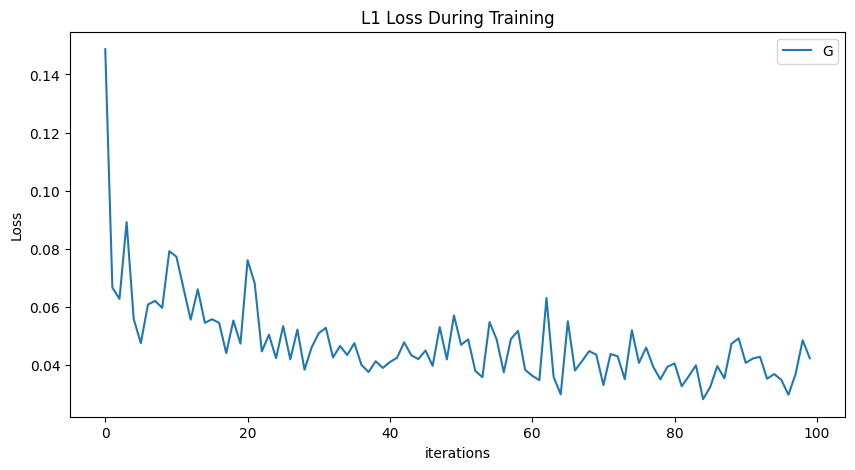

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("L1 Loss During Training")
plt.plot(G_losses,label="G")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

In [11]:
torch.save({
            'epoch': num_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'model_seed_{}.pt'.format(torch.random.initial_seed()))

In [12]:
import cv2

# Load best model
checkpoint = torch.load('model_best.pt')
# checkpoint = torch.load('model_seed_{}.pt'.format(torch.random.initial_seed()))
best_model = idist.auto_model(
    UNet(4)
)

best_model.load_state_dict(checkpoint['model_state_dict'])

root_dir = "dataset"
sony_test_csv_files = ["dataset/Sony_test_list.txt"]

sony_test_dataset = LabeledDataset(root_dir, *sony_test_csv_files, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_test_dataloader = DataLoader(sony_test_dataset, batch_size=1, num_workers=1)


2023-06-14 13:00:10,797 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


Creating buffer for 229 images


tensor(9.9451e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0249, device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(250., device='cuda:0')
0.031971633 0.005162308 0.0 1.0
0.035075545 0.011896274 0.0 1.0
0.035861023 0.028827883 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


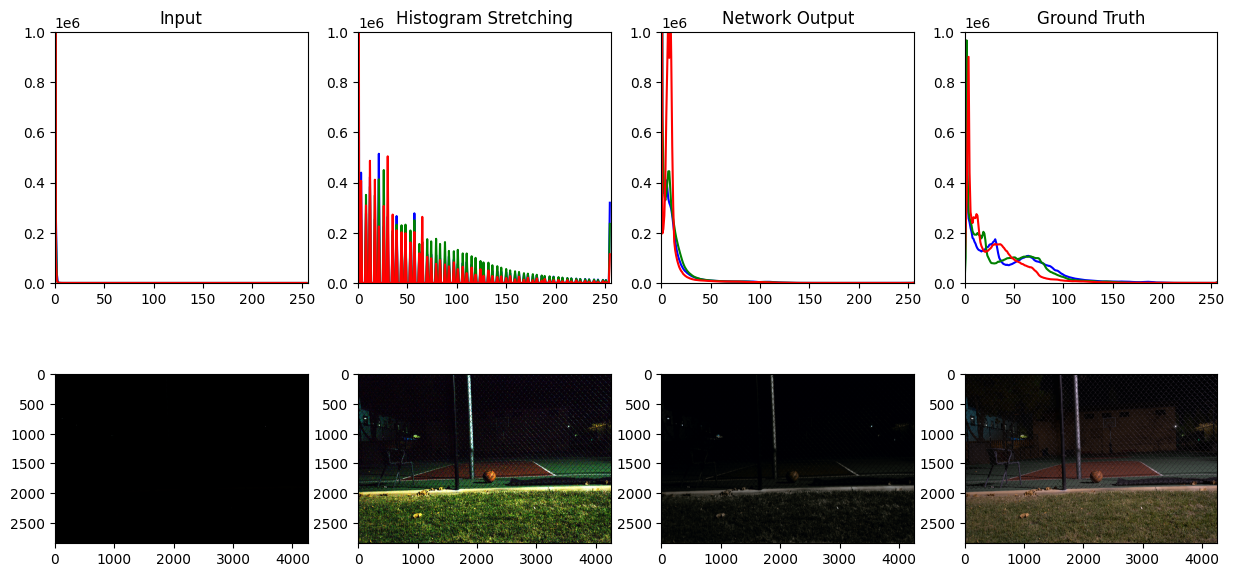

tensor(0.0003, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0.0300, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(100., device='cuda:0')
0.042646706 0.012080701 0.0 1.0
0.040048752 0.017630275 0.0 1.0
0.036549497 0.029515099 0.0 1.0
0.1745267 0.13415731 0.0 1.0
0.15320197 0.12263676 0.0 1.0
0.11769672 0.09105058 0.0 1.0


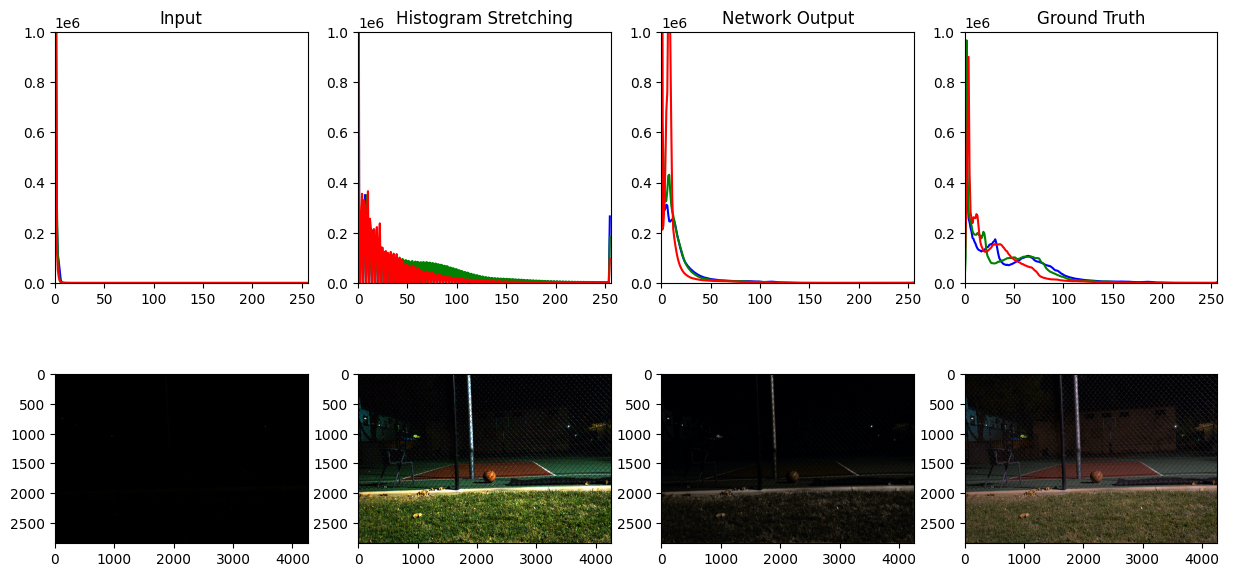

tensor(0.0001, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0129, device='cuda:0')
tensor(0.0317, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(3.2134, device='cuda:0')
0.021497853 0.017041069 0.0 0.70295656
0.023464428 0.020149993 0.0 0.7212949
0.027713686 0.03140936 0.0 0.7156167
0.16390072 0.16130312 0.0 1.0
0.13471788 0.12680247 0.0 1.0
0.13667648 0.1257496 0.0 1.0


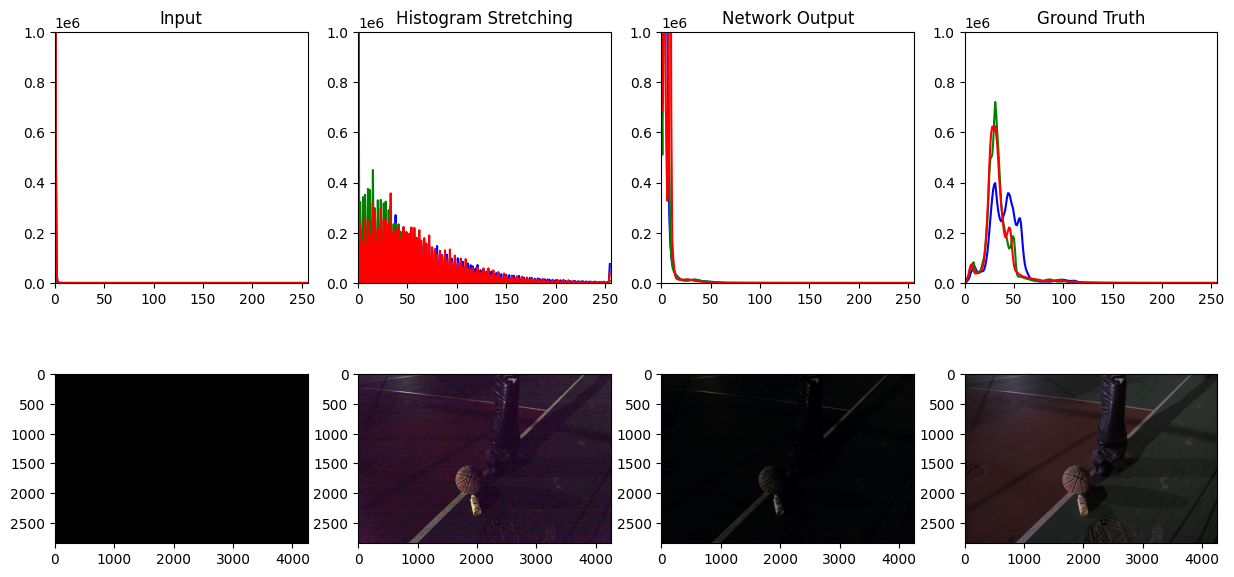

tensor(8.3668e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1387, device='cuda:0')
tensor(0.0209, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(34.6702, device='cuda:0')
0.01714185 0.0067892857 0.0 1.0
0.02093331 0.01311714 0.0 1.0
0.026309231 0.029614214 0.0 1.0
0.1526067 0.1371023 0.0 1.0
0.13751055 0.12762646 0.0 1.0
0.11115194 0.11282521 0.0 1.0


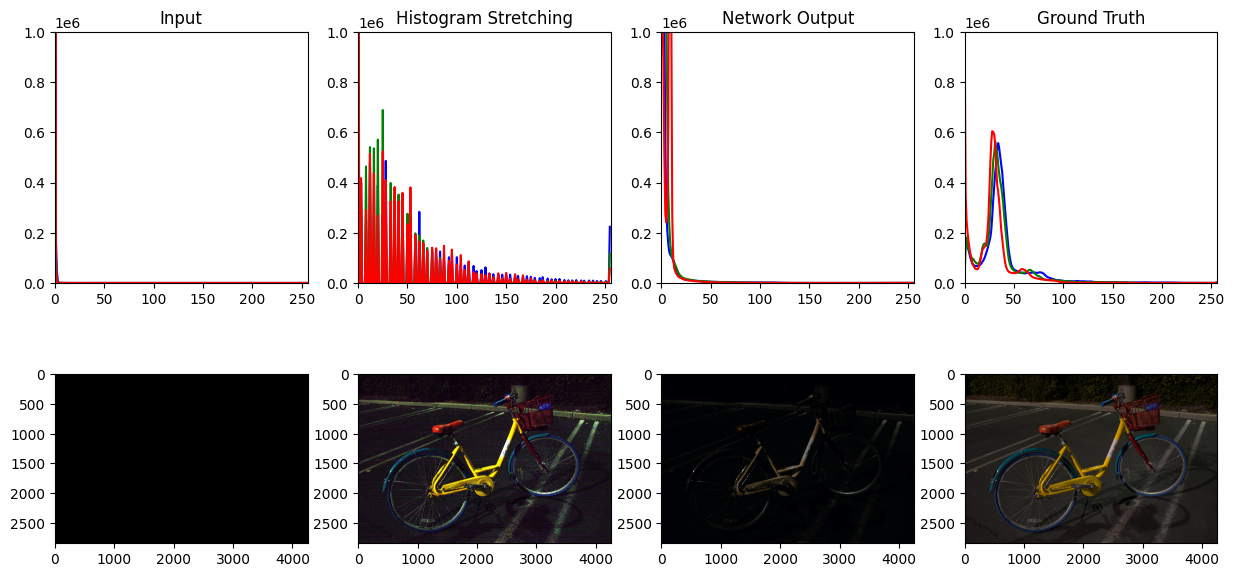

tensor(9.3496e-05, device='cuda:0') tensor(6.3008e-05, device='cuda:0') tensor(0., device='cuda:0') tensor(0.0594, device='cuda:0')
tensor(0.0234, device='cuda:0') tensor(0.0158, device='cuda:0') tensor(0., device='cuda:0') tensor(14.8384, device='cuda:0')
0.02554593 0.0110751055 0.0 1.0
0.025363438 0.0162777 0.0 1.0
0.024494959 0.025399022 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


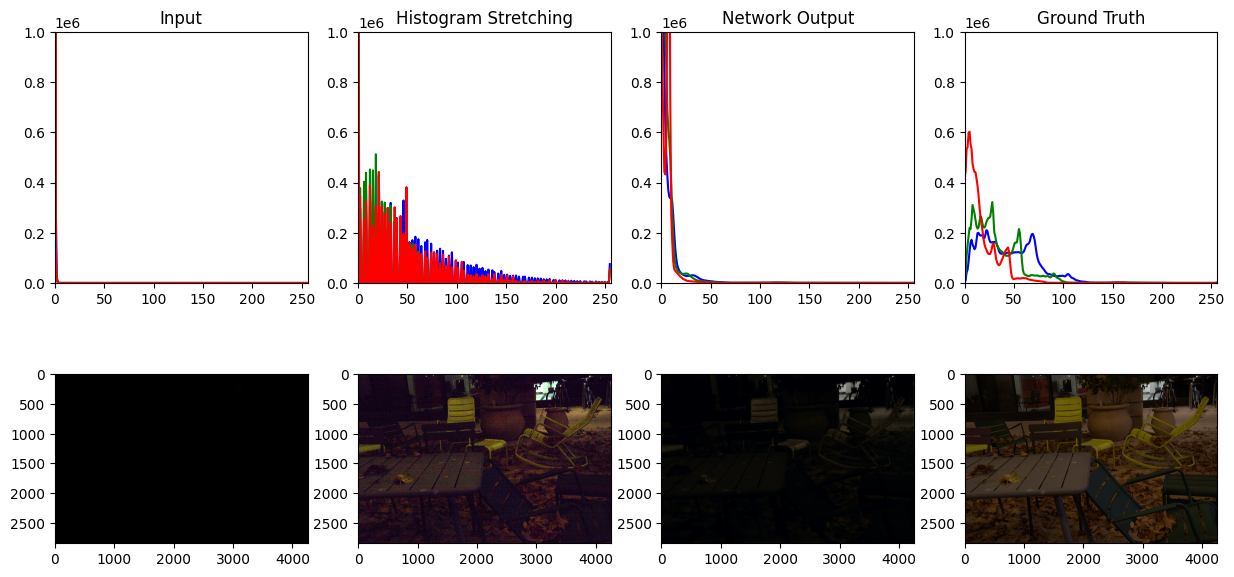

tensor(0.0002, device='cuda:0') tensor(0.0001, device='cuda:0') tensor(0., device='cuda:0') tensor(0.1466, device='cuda:0')
tensor(0.0224, device='cuda:0') tensor(0.0126, device='cuda:0') tensor(0., device='cuda:0') tensor(14.6620, device='cuda:0')
0.0253408 0.010315272 0.0 1.0
0.027767908 0.017531691 0.0 1.0
0.027230443 0.028230343 0.0 1.0
0.17585072 0.16221866 0.0 1.0
0.12842868 0.10785077 0.0 1.0
0.07044467 0.047241934 0.0 1.0


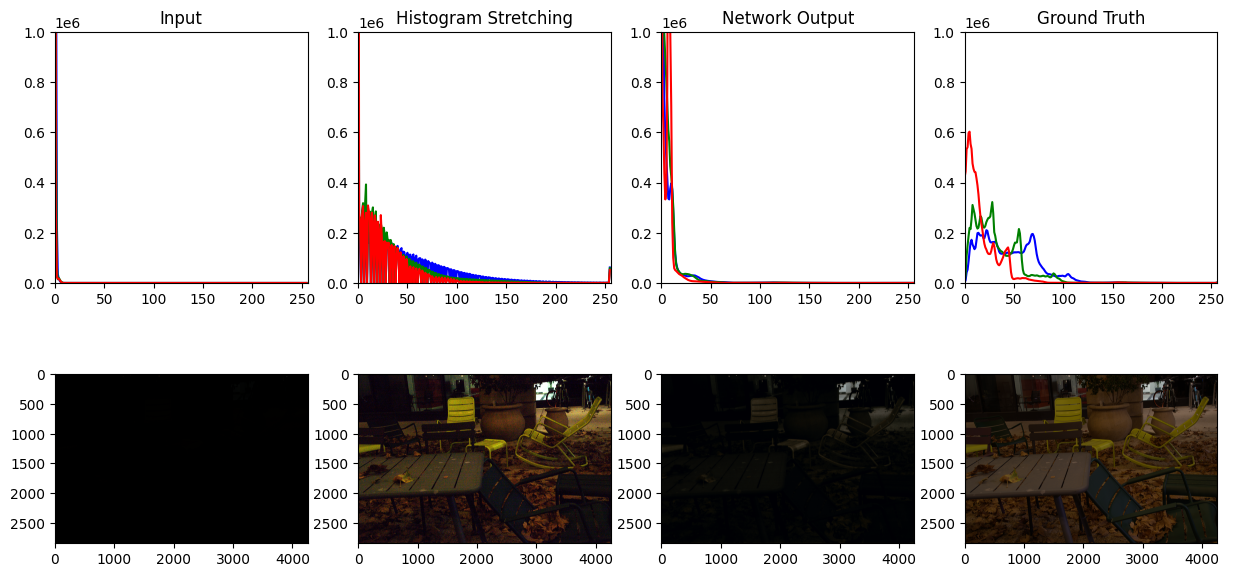

tensor(0.0011, device='cuda:0') tensor(0.0008, device='cuda:0') tensor(0., device='cuda:0') tensor(0.7309, device='cuda:0')
tensor(0.1149, device='cuda:0') tensor(0.0756, device='cuda:0') tensor(0., device='cuda:0') tensor(73.0893, device='cuda:0')
0.24923138 0.2440915 0.0 0.87069196
0.2016577 0.20119512 0.0 1.0
0.16121866 0.156969 0.0 1.0
0.45840585 0.45607692 0.0 1.0
0.36945933 0.37097734 0.004806592 1.0
0.22926527 0.18481727 0.0 1.0


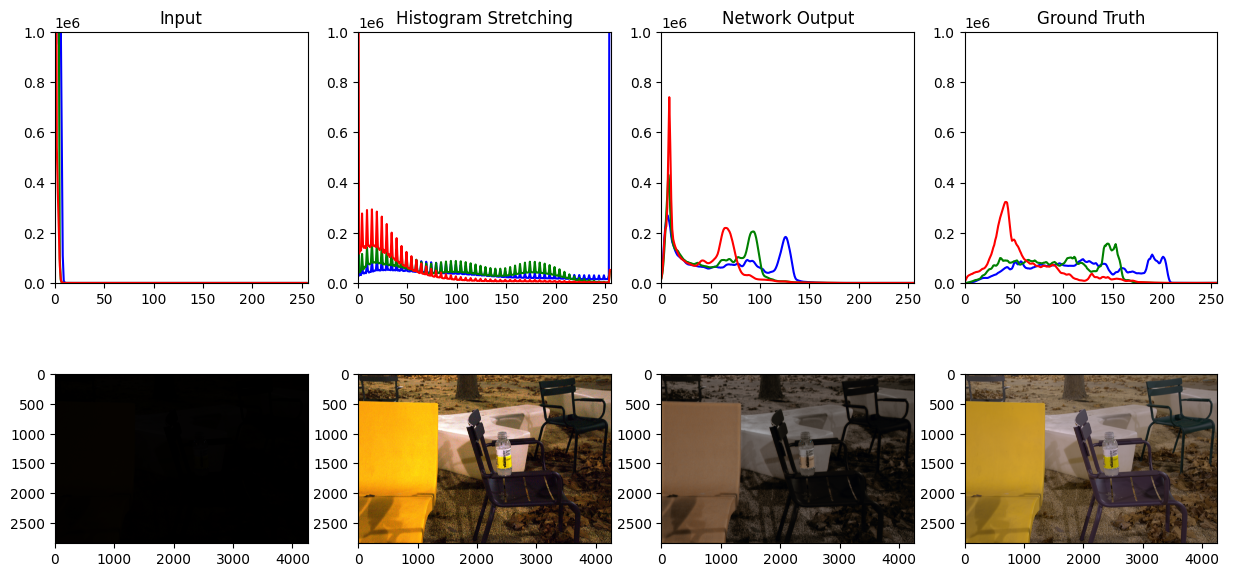

In [13]:
import matplotlib.pyplot as plt

with torch.no_grad():
    best_model.eval()
    list_samp = [1, 13, 27, 39, 51, 61, 73]
    o = 0
    for batch in sony_test_dataloader:
    # batch = next(iter(sony_test_dataloader))
        short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch
        o += 1
        if o > list_samp[-1]:
            break
        if o not in list_samp:
            continue
        short_ = short
        short = short.to(idist.device())
        long = long.to(idist.device())

        short = pack_sony_raw(short)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        long = long / 65535.0
        short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)
        print(torch.mean(short), torch.median(short), torch.min(short), torch.max(short))
        
        
        output = best_model(short)
        # output = torch.nn.functional.pixel_shuffle(output, 2)

        output = output[0, :, :, :].to('cpu').numpy()
        output = np.minimum(np.maximum(output, 0), 1)
        gt_full = long[0, :, :, :].to('cpu').numpy()
        raw_input = short_raw[0, :, :, :].to('cpu').numpy() / 65535.0
        scale_full = np.float32(short_raw[0, :, :, :].to('cpu').numpy() / 65535.0)
        scale_full = scale_full * np.mean(gt_full) / np.mean(scale_full) 

        print(np.mean(output[0]), np.median(output[0]), np.min(output[0]), np.max(output[0]))
        print(np.mean(output[1]), np.median(output[1]), np.min(output[1]), np.max(output[1]))
        print(np.mean(output[2]), np.median(output[2]), np.min(output[2]), np.max(output[2]))
        print(np.mean(gt_full[0]), np.median(gt_full[0]), np.min(gt_full[0]), np.max(gt_full[0]))
        print(np.mean(gt_full[1]), np.median(gt_full[1]), np.min(gt_full[1]), np.max(gt_full[1]))
        print(np.mean(gt_full[2]), np.median(gt_full[2]), np.min(gt_full[2]), np.max(gt_full[2]))

        output = np.minimum(np.transpose(output, (1,2,0)) * 255, 255).astype(np.uint8)
        # output = (output-np.min(output))/(np.max(output)-np.min(output))
        gt_full = np.minimum(np.transpose(gt_full, (1,2,0)) * 255, 255).astype(np.uint8)
        raw_input = np.minimum(raw_input * 255, 255).astype(np.uint8)
        scale_full = np.minimum(scale_full * 255, 255).astype(np.uint8)

        color = ('b','g','r')
        plt.figure(figsize=(15,15))
        ax = plt.subplot(4,4,1)
        ax.set_title("Input")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([raw_input],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,5)
        plt.imshow(raw_input)

        ax = plt.subplot(4,4,2)
        ax.set_title("Histogram Stretching")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([scale_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,6)
        plt.imshow(scale_full)

        ax = plt.subplot(4,4,3)
        ax.set_title("Network Output")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([output],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,7)
        plt.imshow(output)

        ax = plt.subplot(4,4,4)
        ax.set_title("Ground Truth")
        ax.set_ylim([0, 1e6])
        for i,col in enumerate(color):
            histr = cv2.calcHist([gt_full],[i],None,[256],[0,256])
            plt.plot(histr,color = col)
            plt.xlim([0,256])
        plt.subplot(4,4,8)
        plt.imshow(gt_full)
        plt.show()

In [14]:
from ignite.metrics import PSNR, SSIM

def eval_step(engine, batch):
    short, long, ratio, cam_model, exposure_ratio, _, _, short_raw = batch

    short = short.to(idist.device())
    long = long.to(idist.device())

    short = pack_sony_raw(short)
    long = long / 65535.0
    short = short * exposure_ratio.float().to(idist.device()).view(-1, 1, 1, 1)   
    
    output = best_model(short)
    output = torch.minimum(torch.maximum(output, torch.Tensor([0]).to(idist.device())), torch.Tensor([1]).to(idist.device()))

    return output, long

evaluator = Engine(eval_step)
psnr = PSNR(data_range=1.0)
psnr.attach(evaluator, 'psnr')
ssim = SSIM(data_range=1.0)
ssim.attach(evaluator, 'ssim')
ProgressBar().attach(evaluator)

In [15]:
root_dir = "dataset"
sony_val_csv_files = ["dataset/Sony_test_list.txt"]

sony_val_dataset = LabeledDataset(root_dir, *sony_val_csv_files, training=False, transform=transforms.Compose([
    transforms.ToTensor()
]))
sony_val_dataloader = idist.auto_dataloader(sony_val_dataset, batch_size=2, num_workers=8)

Creating buffer for 229 images


2023-06-14 13:02:34,132 ignite.distributed.auto.auto_dataloader INFO: Use data loader kwargs for dataset '<utils.datasets.Labe': 
	{'batch_size': 2, 'num_workers': 8, 'pin_memory': True}


In [16]:
state = evaluator.run(sony_val_dataloader)

In [17]:
print(state.metrics['psnr'])
print(state.metrics['ssim'])

17.248133113124506
0.43120391272404107
